# Taxi New York

In [34]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from geopy import distance
import os
from sklearn.model_selection import cross_val_score
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Data loading

In [2]:
train = pd.read_csv("./input/nyc-taxi-trip-duration/train.csv")
test = pd.read_csv("./input/nyc-taxi-trip-duration/test.csv")
sample = pd.read_csv("./input/nyc-taxi-trip-duration/sample_submission.csv")

## data exploration

In [3]:
train.shape,test.shape,sample.shape

((1458644, 11), (625134, 9), (625134, 2))

In [4]:
train.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [5]:
test.head(10)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N
5,id0668992,1,2016-06-30 23:59:30,1,-73.991302,40.749798,-73.980515,40.786549,N
6,id1765014,1,2016-06-30 23:59:15,1,-73.978310,40.741550,-73.952072,40.717003,N
7,id0898117,1,2016-06-30 23:59:09,2,-74.012711,40.701527,-73.986481,40.719509,N
8,id3905224,2,2016-06-30 23:58:55,2,-73.992332,40.730511,-73.875618,40.875214,N
9,id1543102,2,2016-06-30 23:58:46,1,-73.993179,40.748760,-73.979309,40.761311,N


In [6]:
sample.head(10)

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959
5,id0668992,959
6,id1765014,959
7,id0898117,959
8,id3905224,959
9,id1543102,959


In [7]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


In [8]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [9]:
sample.describe()

,trip_duration
count,625134.0
mean,959.0
std,0.0
min,959.0
25%,959.0
50%,959.0
75%,959.0
max,959.0


In [10]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [11]:
test.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [12]:
sample.isna().sum()

id               0
trip_duration    0
dtype: int64

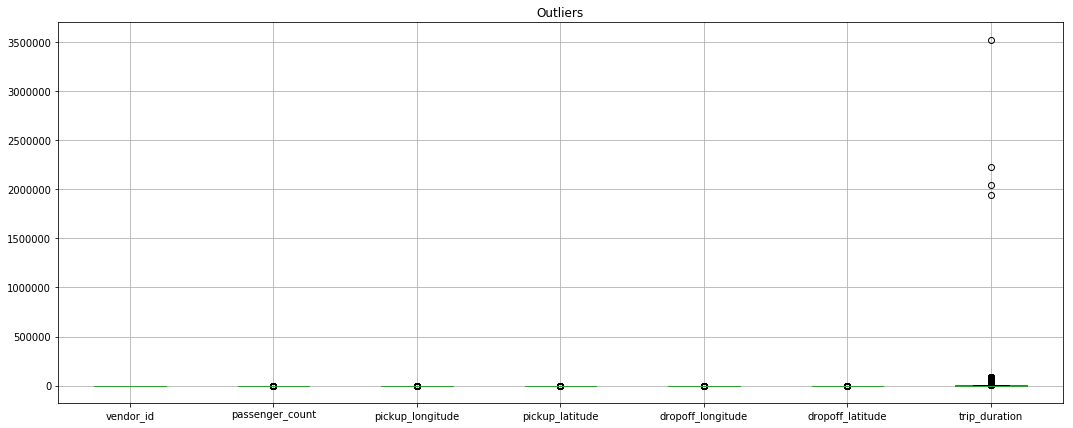

In [13]:
plt.subplots(figsize=(18,7))
plt.title("Outliers")
train.boxplot()

## data cleaning

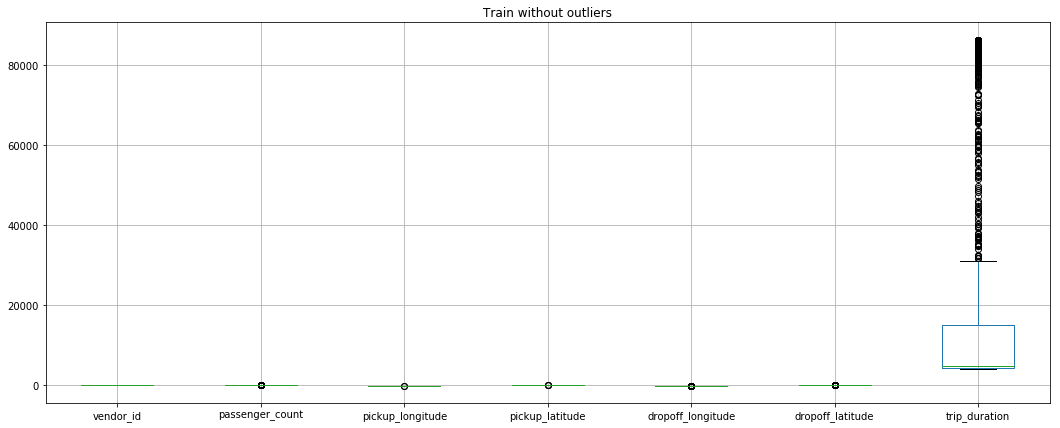

In [14]:
train = train.loc[train['trip_duration']< 1500000]
train = train.loc[train['trip_duration']> 4000]
plt.subplots(figsize=(18,7))
plt.title("Train without outliers")
train.boxplot()

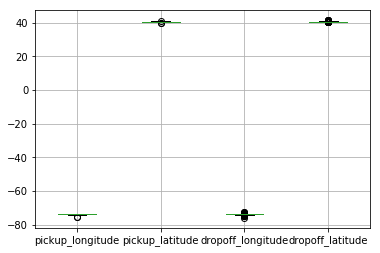

In [15]:
train[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].boxplot()

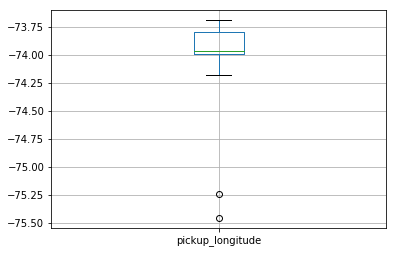

In [16]:
train[['pickup_longitude']].boxplot()

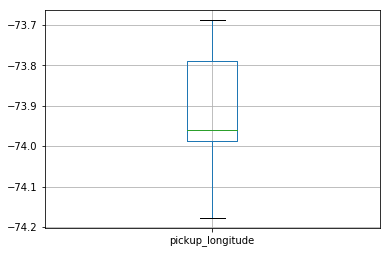

In [19]:
train = train.loc[train['pickup_longitude']>-75]      
train = train.loc[train['pickup_longitude']<-65]         
train[['pickup_longitude']].boxplot()

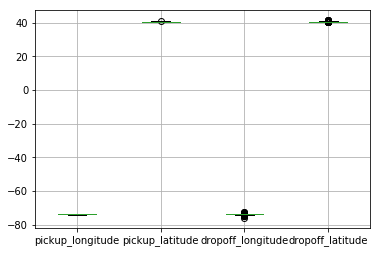

In [20]:
train[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].boxplot()

## Make more data

### Creat column for Day of the week, minute, hour, day and month

In [21]:
train['pickup_datetime']= pd.to_datetime(train.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
train['day_of_the_date']=train.pickup_datetime.dt.dayofweek
train['month'] = train.pickup_datetime.dt.month
train['day'] = train.pickup_datetime.dt.day
train['hour'] = train.pickup_datetime.dt.hour
train['minute'] = train.pickup_datetime.dt.minute
train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_the_date,month,day,hour,minute
354,id3402983,2,2016-06-30 15:48:06,2016-06-30 17:31:13,1,-73.781898,40.644772,-73.985893,40.760159,N,6187,3,6,30,15,48
403,id2693863,1,2016-03-18 08:22:10,2016-03-18 09:47:19,1,-73.777184,40.646500,-73.985001,40.760918,N,5109,4,3,18,8,22
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594,5,2,20,4,3
1057,id0631822,2,2016-05-17 14:17:48,2016-05-17 15:26:06,1,-73.995583,40.716949,-73.789101,40.642448,N,4098,1,5,17,14,17
1113,id3893063,2,2016-06-02 17:32:41,2016-06-02 18:42:43,1,-73.948578,40.778080,-73.781792,40.646790,N,4202,3,6,2,17,32


In [22]:
test['pickup_datetime']= pd.to_datetime(test.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
test['day_of_the_date']=test.pickup_datetime.dt.dayofweek
test['month'] = test.pickup_datetime.dt.month
test['day'] = test.pickup_datetime.dt.day
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_the_date,month,day,hour,minute
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,3,6,30,23,59
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,3,6,30,23,59
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,3,6,30,23,59
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,3,6,30,23,59
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,3,6,30,23,59


### Calculate the distance between pickup point and dropoff point

In [23]:
def distancer(row):
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return distance.distance(coords_1, coords_2).km

train['distance'] = train.apply(distancer, axis=1)
test['distance'] = test.apply(distancer, axis=1)

In [24]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_the_date,month,day,hour,minute,distance
354,id3402983,2,2016-06-30 15:48:06,2016-06-30 17:31:13,1,-73.781898,40.644772,-73.985893,40.760159,N,6187,3,6,30,15,48,21.480365
403,id2693863,1,2016-03-18 08:22:10,2016-03-18 09:47:19,1,-73.777184,40.646500,-73.985001,40.760918,N,5109,4,3,18,8,22,21.676980
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594,5,2,20,4,3,2.988912
1057,id0631822,2,2016-05-17 14:17:48,2016-05-17 15:26:06,1,-73.995583,40.716949,-73.789101,40.642448,N,4098,1,5,17,14,17,19.317473
1113,id3893063,2,2016-06-02 17:32:41,2016-06-02 18:42:43,1,-73.948578,40.778080,-73.781792,40.646790,N,4202,3,6,2,17,32,20.277768


In [25]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_the_date,month,day,hour,minute,distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,3,6,30,23,59,2.742863
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,3,6,30,23,59,2.755774
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,3,6,30,23,59,1.307112
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,3,6,30,23,59,5.266978
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,3,6,30,23,59,0.961745


## Features selection

In [26]:
train.columns,test.columns

(Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
        'passenger_count', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
        'trip_duration', 'day_of_the_date', 'month', 'day', 'hour', 'minute',
        'distance'],
       dtype='object'),
 Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'store_and_fwd_flag', 'day_of_the_date', 'month',
        'day', 'hour', 'minute', 'distance'],
       dtype='object'))

In [27]:
input_columns=['day_of_the_date', 'month', 'day', 'hour', 'minute','distance']
y=train['trip_duration']
X=train[input_columns]
X_test=test[input_columns]

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)

In [29]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6630, 6), (1658, 6), (6630,), (1658,))

## Entrainement

In [32]:
rfr = RandomForestRegressor(n_estimators=19, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=80, bootstrap=True)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
#rf = RandomForestClassifier(n_estimators=13)
#rf.fit(X_train, y_train)

In [39]:
cv_scores = cross_val_score(rfr, X_train, y_train, cv=5)
for i in range (len (cv_scores)):
    cv_scores[i]=np.sqrt(abs(cv_scores[i]))
print(np.mean(cv_scores))

0.8020027485473442


## Submission

In [43]:
train_pred=rfr.predict(X_test)
train_pred

array([79131.58687818, 79131.58687818, 74414.32357978, ...,
       53239.16418961, 10100.37346017, 69971.47982646])

In [45]:
len(train_pred)

625134

In [47]:
sample = pd.read_csv("./input/nyc-taxi-trip-duration/sample_submission.csv")

In [48]:
my_submission = pd.DataFrame({'id':test.id, 'trip_duration':train_pred})